In [3]:
import os
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchmetrics import FBetaScore, ConfusionMatrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

from modular import data_setup, engine, model_builder, utils

import random
from timeit import default_timer as timer
from datetime import datetime

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Creating a directory
data_path = Path("data/")
data_path.mkdir(parents=True,exist_ok=True)

In [13]:
# Extracting the contents of a ZIP file named "water_bottle_level.zip" into the specified data path.
with zipfile.ZipFile("water_bottle_level.zip") as z:
  z.extractall(data_path)

In [5]:
# Creating a DataFrame with Image Paths and Corresponding Classes from a Directory Structure
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df = pd.DataFrame(image_list)

In [6]:
df.head()

,path,classes
0,data\Full Water level\Full Water level\-on-w...,Full Water level
1,data\Full Water level\Full Water level\01-wa...,Full Water level
2,data\Full Water level\Full Water level\0bnC0...,Full Water level
3,data\Full Water level\Full Water level\1-0l-...,Full Water level
4,data\Full Water level\Full Water level\1000_...,Full Water level


In [7]:
df.shape

(429, 2)

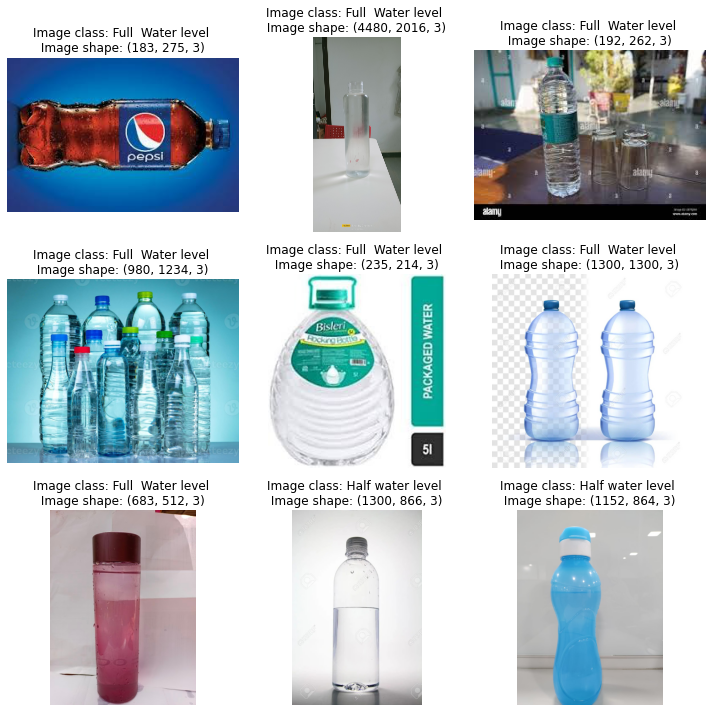

In [8]:
# Displaying a random sample of images along with their classes and shapes in a 3x3 grid.
def plot_image(data):

    rnd_sample = df.sample(9)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for ax, path in zip(axes, rnd_sample["path"]):
        img_class = rnd_sample[rnd_sample["path"] == path]["classes"].iloc[0]

        img = Image.open(path)
        img_as_array = np.array(img)
        ax.imshow(img_as_array)
        ax.set_title(f"Image class: {img_class} \n Image shape: {img_as_array.shape} ")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_image(df)

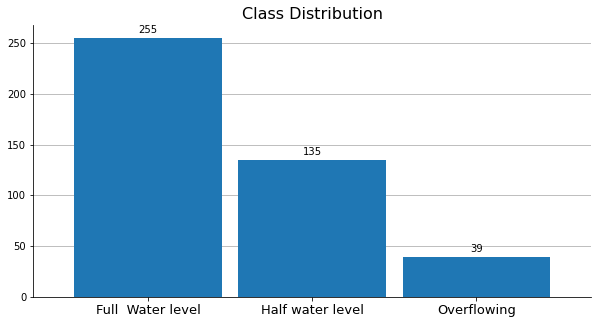

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Class Distribution", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")


* We have a small and imbalanced dataset. 
* We need to increase the number of data and choose an appropriate metric for the imbalanced distribution.

In [10]:
full_data_directory = "data/Full  Water level"
half_data_directory = "data/Half water level"
overflowing_data_directory = "data/Overflowing"

In [11]:
# Augmenting datasets by creating additional images for three different classes: 
# one from a full data directory, one from a half data directory, and one from an overflowing data directory, each with 500 new images.
data_setup.augment_dataset(class_dir=full_data_directory)
data_setup.augment_dataset(class_dir=half_data_directory)
data_setup.augment_dataset(class_dir=overflowing_data_directory)

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
image_list = []

for dirpath, dirnames, filenames in os.walk(data_path):
    for filename in filenames:
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            image_list.append({"path": dirpath+os.sep+filename, "classes": os.path.basename(dirpath)})

df_ = pd.DataFrame(image_list)

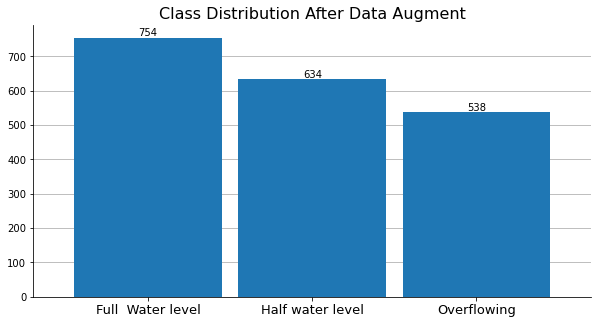

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
counts = df_.classes.value_counts()
counts.plot.bar(width=0.9, rot=0, ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(which="both", axis="y")
ax.set_axisbelow(True)

ax.set_title("Class Distribution After Data Augment", fontsize=16)
ax.tick_params(axis="x", labelsize=13)
for pos, value in enumerate(counts):
    ax.text(pos, value + 5, f"{value}", ha="center")

In [14]:
# Creating a model
model, data_transform = model_builder.create_model(model_name="EfficientNet_B0", num_classes=3)

In [15]:
# Creating dataframes 
train_df, test_df = data_setup.create_dataframe(data_path=data_path)
# Transforming the training and validation data
train_data_transformed = data_setup.CustomImageFolder(train_df,transform=data_transform)
test_data_transformed = data_setup.CustomImageFolder(test_df,transform=data_transform)

In [16]:
class_names=train_data_transformed.classes

In [17]:
# Creating data loaders 
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_df,
    test_dir=test_df,
    transform=data_transform,
    batch_size=32,
)

In [18]:
# Setting the computing device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
# Creating an FBetaScore metric for multiclass classification with a specific beta value
fbeta_score = FBetaScore(task="multiclass", num_classes=len(class_names), beta=0.5).to(
    device
)

In [20]:
def create_writer(
    experiment_name="500_data",
    loss_fn="MultiMarginLoss_fn",
    model_name="EfficientNet_B0",
    epoch="50_epochs",
    lr="1e-4_lr",
) -> torch.utils.tensorboard.writer.SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        epoch (str): Epoch number.
        lr (str): Learning rate used in the experiment.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter: Instance of a writer saving to log_dir.


    """
    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime(
        "%d-%m-%Y,%H-%M-%S"
    )  # returns current date in DD-MM-YYYY,H-M-S format

    log_dir_parts = ["runs", timestamp, experiment_name, model_name, loss_fn, epoch, lr]

    # Create log directory path
    log_dir = os.path.join(*log_dir_parts)
    print(log_dir)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

### Train model
* Loss function = Cross Entropy Loss

In [21]:
# Set the loss function and optimizer
cross_entropy_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# Start the timer
start_time = timer()

# Starting training
results_ce = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=cross_entropy_loss,
    epochs=50,
    fbeta_score=fbeta_score,
    device=device,
    writer=create_writer(),
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print("-" * 50 + "\n")

runs\19-08-2023,14-14-48\500_data\EfficientNet_B0\CrossEntropyLoss_fn\50_epochs\1e-4_lr
[INFO] Created SummaryWriter, saving to: runs\19-08-2023,14-14-48\500_data\EfficientNet_B0\CrossEntropyLoss_fn\50_epochs\1e-4_lr...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
 train_loss: 1.0580 | train_f0.5_score: 46.0% | 
 val_loss: 0.9876 | val_f0.5_score: 65.0% | 


  2%|▏         | 1/50 [01:44<1:25:04, 104.17s/it]

Epoch: 2 
 train_loss: 0.9502 | train_f0.5_score: 63.0% | 
 val_loss: 0.8862 | val_f0.5_score: 73.0% | 


  4%|▍         | 2/50 [02:58<1:09:20, 86.68s/it] 

Epoch: 3 
 train_loss: 0.8684 | train_f0.5_score: 72.0% | 
 val_loss: 0.8103 | val_f0.5_score: 81.0% | 


  6%|▌         | 3/50 [04:13<1:03:50, 81.50s/it]

Epoch: 4 
 train_loss: 0.7994 | train_f0.5_score: 76.0% | 
 val_loss: 0.7502 | val_f0.5_score: 82.0% | 


  8%|▊         | 4/50 [05:28<1:00:29, 78.91s/it]

Epoch: 5 
 train_loss: 0.7469 | train_f0.5_score: 77.0% | 
 val_loss: 0.6993 | val_f0.5_score: 84.0% | 


 10%|█         | 5/50 [06:44<58:13, 77.63s/it]  

Epoch: 6 
 train_loss: 0.6954 | train_f0.5_score: 79.0% | 
 val_loss: 0.6502 | val_f0.5_score: 84.0% | 


 12%|█▏        | 6/50 [08:10<59:07, 80.61s/it]

Epoch: 7 
 train_loss: 0.6704 | train_f0.5_score: 80.0% | 
 val_loss: 0.6229 | val_f0.5_score: 85.0% | 


 14%|█▍        | 7/50 [09:31<57:45, 80.59s/it]

Epoch: 8 
 train_loss: 0.6422 | train_f0.5_score: 80.0% | 
 val_loss: 0.5993 | val_f0.5_score: 84.0% | 


 16%|█▌        | 8/50 [10:51<56:18, 80.43s/it]

Epoch: 9 
 train_loss: 0.6171 | train_f0.5_score: 82.0% | 
 val_loss: 0.5587 | val_f0.5_score: 86.0% | 


 18%|█▊        | 9/50 [12:24<57:36, 84.30s/it]

Epoch: 10 
 train_loss: 0.5861 | train_f0.5_score: 83.0% | 
 val_loss: 0.5355 | val_f0.5_score: 86.0% | 


 20%|██        | 10/50 [13:48<56:11, 84.28s/it]

Epoch: 11 
 train_loss: 0.5634 | train_f0.5_score: 82.0% | 
 val_loss: 0.5254 | val_f0.5_score: 86.0% | 


 22%|██▏       | 11/50 [15:10<54:17, 83.51s/it]

Epoch: 12 
 train_loss: 0.5526 | train_f0.5_score: 83.0% | 
 val_loss: 0.5018 | val_f0.5_score: 86.0% | 


 24%|██▍       | 12/50 [16:27<51:47, 81.78s/it]

Epoch: 13 
 train_loss: 0.5352 | train_f0.5_score: 84.0% | 
 val_loss: 0.4908 | val_f0.5_score: 87.0% | 


 26%|██▌       | 13/50 [17:45<49:42, 80.61s/it]

Epoch: 14 
 train_loss: 0.5218 | train_f0.5_score: 84.0% | 
 val_loss: 0.4772 | val_f0.5_score: 87.0% | 


 28%|██▊       | 14/50 [19:05<48:14, 80.40s/it]

Epoch: 15 
 train_loss: 0.4996 | train_f0.5_score: 85.0% | 
 val_loss: 0.4621 | val_f0.5_score: 87.0% | 


 30%|███       | 15/50 [20:27<47:03, 80.66s/it]

Epoch: 16 
 train_loss: 0.4924 | train_f0.5_score: 84.0% | 
 val_loss: 0.4505 | val_f0.5_score: 88.0% | 


 32%|███▏      | 16/50 [21:52<46:35, 82.21s/it]

Epoch: 17 
 train_loss: 0.4785 | train_f0.5_score: 85.0% | 
 val_loss: 0.4366 | val_f0.5_score: 88.0% | 


 34%|███▍      | 17/50 [23:18<45:46, 83.23s/it]

Epoch: 18 
 train_loss: 0.4795 | train_f0.5_score: 84.0% | 
 val_loss: 0.4293 | val_f0.5_score: 88.0% | 


 36%|███▌      | 18/50 [24:42<44:32, 83.53s/it]

Epoch: 19 
 train_loss: 0.4563 | train_f0.5_score: 87.0% | 
 val_loss: 0.4218 | val_f0.5_score: 87.0% | 


 38%|███▊      | 19/50 [26:05<43:02, 83.31s/it]

Epoch: 20 
 train_loss: 0.4535 | train_f0.5_score: 87.0% | 
 val_loss: 0.4180 | val_f0.5_score: 88.0% | 


 40%|████      | 20/50 [27:39<43:16, 86.57s/it]

Epoch: 21 
 train_loss: 0.4475 | train_f0.5_score: 86.0% | 
 val_loss: 0.4001 | val_f0.5_score: 88.0% | 


 42%|████▏     | 21/50 [29:37<46:27, 96.11s/it]

Epoch: 22 
 train_loss: 0.4486 | train_f0.5_score: 85.0% | 
 val_loss: 0.4009 | val_f0.5_score: 89.0% | 


 44%|████▍     | 22/50 [31:22<46:03, 98.70s/it]

Epoch: 23 
 train_loss: 0.4453 | train_f0.5_score: 86.0% | 
 val_loss: 0.3900 | val_f0.5_score: 89.0% | 


 46%|████▌     | 23/50 [33:09<45:29, 101.09s/it]

Epoch: 24 
 train_loss: 0.4237 | train_f0.5_score: 87.0% | 
 val_loss: 0.3916 | val_f0.5_score: 88.0% | 


 48%|████▊     | 24/50 [35:00<45:07, 104.15s/it]

Epoch: 25 
 train_loss: 0.4117 | train_f0.5_score: 88.0% | 
 val_loss: 0.3783 | val_f0.5_score: 89.0% | 


 50%|█████     | 25/50 [36:39<42:47, 102.69s/it]

Epoch: 26 
 train_loss: 0.4219 | train_f0.5_score: 86.0% | 
 val_loss: 0.3720 | val_f0.5_score: 88.0% | 


 52%|█████▏    | 26/50 [38:19<40:42, 101.77s/it]

Epoch: 27 
 train_loss: 0.4083 | train_f0.5_score: 88.0% | 
 val_loss: 0.3639 | val_f0.5_score: 89.0% | 


 54%|█████▍    | 27/50 [40:04<39:24, 102.80s/it]

Epoch: 28 
 train_loss: 0.4046 | train_f0.5_score: 86.0% | 
 val_loss: 0.3633 | val_f0.5_score: 89.0% | 


 56%|█████▌    | 28/50 [41:48<37:48, 103.13s/it]

Epoch: 29 
 train_loss: 0.3923 | train_f0.5_score: 88.0% | 
 val_loss: 0.3531 | val_f0.5_score: 89.0% | 


 58%|█████▊    | 29/50 [43:15<34:23, 98.28s/it] 

Epoch: 30 
 train_loss: 0.4010 | train_f0.5_score: 87.0% | 
 val_loss: 0.3507 | val_f0.5_score: 89.0% | 


 60%|██████    | 30/50 [44:42<31:40, 95.00s/it]

Epoch: 31 
 train_loss: 0.3847 | train_f0.5_score: 89.0% | 
 val_loss: 0.3450 | val_f0.5_score: 90.0% | 


 62%|██████▏   | 31/50 [46:10<29:24, 92.89s/it]

Epoch: 32 
 train_loss: 0.3974 | train_f0.5_score: 88.0% | 
 val_loss: 0.3416 | val_f0.5_score: 89.0% | 


 64%|██████▍   | 32/50 [47:40<27:32, 91.83s/it]

Epoch: 33 
 train_loss: 0.3806 | train_f0.5_score: 88.0% | 
 val_loss: 0.3416 | val_f0.5_score: 90.0% | 


 66%|██████▌   | 33/50 [49:07<25:36, 90.41s/it]

Epoch: 34 
 train_loss: 0.3766 | train_f0.5_score: 88.0% | 
 val_loss: 0.3423 | val_f0.5_score: 90.0% | 


 68%|██████▊   | 34/50 [50:38<24:10, 90.65s/it]

Epoch: 35 
 train_loss: 0.3605 | train_f0.5_score: 89.0% | 
 val_loss: 0.3249 | val_f0.5_score: 90.0% | 


 70%|███████   | 35/50 [52:03<22:14, 88.96s/it]

Epoch: 36 
 train_loss: 0.3804 | train_f0.5_score: 87.0% | 
 val_loss: 0.3312 | val_f0.5_score: 90.0% | 


 72%|███████▏  | 36/50 [53:30<20:37, 88.42s/it]

Epoch: 37 
 train_loss: 0.3506 | train_f0.5_score: 89.0% | 
 val_loss: 0.3167 | val_f0.5_score: 90.0% | 


 74%|███████▍  | 37/50 [54:56<18:57, 87.54s/it]

Epoch: 38 
 train_loss: 0.3499 | train_f0.5_score: 89.0% | 
 val_loss: 0.3172 | val_f0.5_score: 89.0% | 


 76%|███████▌  | 38/50 [56:24<17:32, 87.71s/it]

Epoch: 39 
 train_loss: 0.3493 | train_f0.5_score: 89.0% | 
 val_loss: 0.3175 | val_f0.5_score: 90.0% | 


 78%|███████▊  | 39/50 [57:49<15:57, 87.03s/it]

Epoch: 40 
 train_loss: 0.3712 | train_f0.5_score: 88.0% | 
 val_loss: 0.3116 | val_f0.5_score: 90.0% | 


 80%|████████  | 40/50 [59:23<14:50, 89.03s/it]

Epoch: 41 
 train_loss: 0.3466 | train_f0.5_score: 89.0% | 
 val_loss: 0.3080 | val_f0.5_score: 91.0% | 


 82%|████████▏ | 41/50 [1:01:41<15:33, 103.68s/it]

Epoch: 42 
 train_loss: 0.3465 | train_f0.5_score: 89.0% | 
 val_loss: 0.3102 | val_f0.5_score: 91.0% | 


 84%|████████▍ | 42/50 [1:03:24<13:47, 103.46s/it]

Epoch: 43 
 train_loss: 0.3423 | train_f0.5_score: 89.0% | 
 val_loss: 0.2960 | val_f0.5_score: 91.0% | 


 86%|████████▌ | 43/50 [1:05:00<11:47, 101.13s/it]

Epoch: 44 
 train_loss: 0.3658 | train_f0.5_score: 87.0% | 
 val_loss: 0.3002 | val_f0.5_score: 91.0% | 


 88%|████████▊ | 44/50 [1:06:33<09:53, 98.95s/it] 

Epoch: 45 
 train_loss: 0.3458 | train_f0.5_score: 88.0% | 
 val_loss: 0.2951 | val_f0.5_score: 91.0% | 


 90%|█████████ | 45/50 [1:08:01<07:57, 95.41s/it]

Epoch: 46 
 train_loss: 0.3347 | train_f0.5_score: 89.0% | 
 val_loss: 0.2932 | val_f0.5_score: 91.0% | 


 92%|█████████▏| 46/50 [1:09:39<06:24, 96.22s/it]

Epoch: 47 
 train_loss: 0.3473 | train_f0.5_score: 88.0% | 
 val_loss: 0.2900 | val_f0.5_score: 91.0% | 


 94%|█████████▍| 47/50 [1:11:29<05:01, 100.50s/it]

Epoch: 48 
 train_loss: 0.3331 | train_f0.5_score: 90.0% | 
 val_loss: 0.2849 | val_f0.5_score: 92.0% | 


 96%|█████████▌| 48/50 [1:13:13<03:23, 101.64s/it]

Epoch: 49 
 train_loss: 0.3369 | train_f0.5_score: 88.0% | 
 val_loss: 0.2890 | val_f0.5_score: 92.0% | 


 98%|█████████▊| 49/50 [1:14:58<01:42, 102.52s/it]

Epoch: 50 
 train_loss: 0.3402 | train_f0.5_score: 88.0% | 
 val_loss: 0.2824 | val_f0.5_score: 91.0% | 


100%|██████████| 50/50 [1:16:42<00:00, 92.05s/it] 

[INFO] Total training time: 4602.729 seconds
--------------------------------------------------



### Train model
* Loss function = Multi Margin Loss

In [21]:
# Set the loss function and optimizer
multi_margin_loss = torch.nn.MultiMarginLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
# Start the timer
start_time = timer()

# Starting training
results_mm = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=multi_margin_loss,
    epochs=10,
    fbeta_score=fbeta_score,
    device=device,
    writer=create_writer(),
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
print("-" * 50 + "\n")

runs\21-08-2023,17-46-33\500_data\EfficientNet_B0\MultiMarginLoss_fn\50_epochs\1e-4_lr
[INFO] Created SummaryWriter, saving to: runs\21-08-2023,17-46-33\500_data\EfficientNet_B0\MultiMarginLoss_fn\50_epochs\1e-4_lr...


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [32, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Resize.cpp:24.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\emirh\anaconda3\envs\wbottle\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [4, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can e

Epoch: 1 
 train_loss: 0.6023 | train_f0.5_score: 45.0% | 
 val_loss: 0.5352 | val_f0.5_score: 61.0% | 


 10%|█         | 1/10 [01:38<14:42, 98.03s/it]

Epoch: 2 
 train_loss: 0.4833 | train_f0.5_score: 61.0% | 
 val_loss: 0.4233 | val_f0.5_score: 71.0% | 


 20%|██        | 2/10 [02:55<11:25, 85.75s/it]

Epoch: 3 
 train_loss: 0.3891 | train_f0.5_score: 72.0% | 
 val_loss: 0.3412 | val_f0.5_score: 76.0% | 


 30%|███       | 3/10 [05:40<14:14, 122.10s/it]

Epoch: 4 
 train_loss: 0.3196 | train_f0.5_score: 75.0% | 
 val_loss: 0.2874 | val_f0.5_score: 78.0% | 


 40%|████      | 4/10 [08:39<14:27, 144.54s/it]

Epoch: 5 
 train_loss: 0.2845 | train_f0.5_score: 79.0% | 
 val_loss: 0.2604 | val_f0.5_score: 79.0% | 


 50%|█████     | 5/10 [11:33<12:55, 155.18s/it]

Epoch: 6 
 train_loss: 0.2522 | train_f0.5_score: 80.0% | 
 val_loss: 0.2391 | val_f0.5_score: 79.0% | 


 60%|██████    | 6/10 [14:11<10:24, 156.17s/it]

Epoch: 7 
 train_loss: 0.2374 | train_f0.5_score: 80.0% | 
 val_loss: 0.2274 | val_f0.5_score: 80.0% | 


 70%|███████   | 7/10 [16:46<07:47, 155.74s/it]

Epoch: 8 
 train_loss: 0.2262 | train_f0.5_score: 80.0% | 
 val_loss: 0.2075 | val_f0.5_score: 81.0% | 


 80%|████████  | 8/10 [19:22<05:11, 155.82s/it]

Epoch: 9 
 train_loss: 0.2120 | train_f0.5_score: 82.0% | 
 val_loss: 0.1980 | val_f0.5_score: 81.0% | 


 90%|█████████ | 9/10 [22:01<02:36, 156.71s/it]

Epoch: 10 
 train_loss: 0.1997 | train_f0.5_score: 84.0% | 
 val_loss: 0.1900 | val_f0.5_score: 81.0% | 


100%|██████████| 10/10 [24:33<00:00, 147.31s/it]

[INFO] Total training time: 1473.119 seconds
--------------------------------------------------



### Evaluate model by plotting loss curves

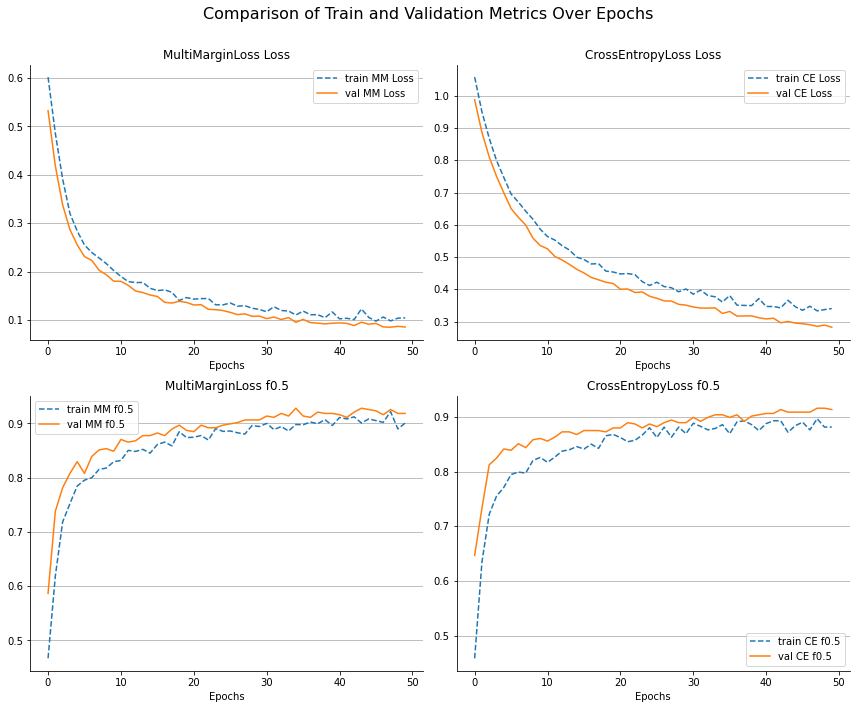

In [44]:
import matplotlib.pyplot as plt

def plot_curves(results_mm, results_ce):
    metric_names = [("loss", "Loss"), ("fbeta_score", "f0.5")]
    epochs = range(len(results_mm["train_loss"]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Comparison of Train and Test Metrics Over Epochs", fontsize=16)

    for row, (metric, label) in enumerate(metric_names):
        # Plot results for MultiMarginLoss
        axes[row, 0].plot(epochs, results_mm[f"train_{metric}"], label=f"train MM {label}", linestyle='--')
        axes[row, 0].plot(epochs, results_mm[f"test_{metric}"], label=f"test MM {label}")
        axes[row, 0].set_title(f"MultiMarginLoss {label}")
        axes[row, 0].set_xlabel("Epochs")
        axes[row, 0].legend()
        
        # Plot results for CrossEntropyLoss
        axes[row, 1].plot(epochs, results_ce[f"train_{metric}"], label=f"train CE {label}", linestyle='--')
        axes[row, 1].plot(epochs, results_ce[f"test_{metric}"], label=f"test CE {label}")
        axes[row, 1].set_title(f"CrossEntropyLoss {label}")
        axes[row, 1].set_xlabel("Epochs")
        axes[row, 1].legend()
        
        for ax in axes[row]:
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.grid(which="both", axis="y")
            ax.set_axisbelow(True)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call the modified function with the results_mm and results_ce dictionaries
plot_curves(results_mm, results_ce)

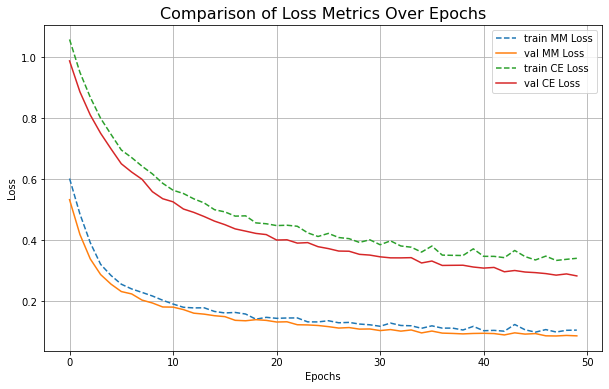

In [45]:
def plot_curves(results_mm, results_ce):
    metric_name = "loss"
    epochs = range(len(results_mm["train_loss"]))

    plt.figure(figsize=(10, 6))
    plt.title("Comparison of Different Loss Metrics Over Epochs", fontsize=16)

    plt.plot(epochs, results_mm[f"train_{metric_name}"], label="train MM Loss", linestyle='--')
    plt.plot(epochs, results_mm[f"test_{metric_name}"], label="test MM Loss")
    plt.plot(epochs, results_ce[f"train_{metric_name}"], label="train CE Loss", linestyle='--')
    plt.plot(epochs, results_ce[f"test_{metric_name}"], label="test CE Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the modified function with the results_mm and results_ce dictionaries
plot_curves(results_mm, results_ce)

In [27]:
model_filepath = (
    f"EfficientNetB0_10_epochs_loss_function_MultiMarginLoss_1e-4_lr.pth"
)
utils.save_model(model=model, target_dir="models", model_name=model_filepath)

[INFO] Saving model to: models\EfficientNetB0_10_epochs_loss_function_MultiMarginLoss_1e-4_lr.pth


In [30]:
models_dir = Path("models/")

In [37]:
 model_filepath= (
    f"EfficientNetB0_10_epochs_loss_function_MultiMarginLoss_1e-4_lr.pth"
)
model_path = models_dir / model_filepath
pretrained_effnetB0_model_size = Path(model_path).stat().st_size / (1024*1024)
print(f"Pretrained effnetB0 model size: {pretrained_effnetB0_model_size} MB")

Pretrained effnetB0 model size: 15.608817100524902 MB


In [39]:
# Count number of parameters
effnetB0_total_params = sum(torch.numel(param) for param in model.parameters())

In [42]:
effnetB0_stats = {"test_loss": results_mm["test_loss"][-1],
                    "test_f0.5_score": results_mm["test_fbeta_score"][-1],
                    "number_of_parameters": effnetB0_total_params,
                    "model_size (MB)": pretrained_effnetB0_model_size}

In [43]:
effnetB0_stats

{'test_loss': array(0.19001123, dtype=float32),
 'test_f0.5_score': array(0.8100962, dtype=float32),
 'number_of_parameters': 4011391,
 'model_size (MB)': 15.608817100524902}

In [52]:
#  Creating a function to make predictions across the test dataseT
def pred_and_store(test_paths, model, transform, class_names, device):
    predictions = []

    for index, row in test_paths.iterrows():
            prediction_dict = {}

            # Get the sample path and ground truth class name
            path = row['path']  # Replace 'path_column_name' with the actual column name
            ground_truth_class = row['classes']  # Replace 'ground_truth_column_name'

            start_time = timer()
        
            img = Image.open(path)
            transformed_image = transform(img).unsqueeze(0).to(device) 

            model.to(device)
            model.eval()

            with torch.inference_mode():
                pred_logit = model(transformed_image) 
                pred_prob = torch.softmax(pred_logit, dim=1) 
                pred_label = torch.argmax(pred_prob, dim=1) 
                pred_class = class_names[pred_label.cpu()]

                prediction_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
                prediction_dict["pred_class"] = pred_class

                end_time = timer()
                prediction_dict["time_for_pred"] = round(end_time-start_time, 4)
            prediction_dict["correct"] = ground_truth_class == pred_class
            predictions.append(prediction_dict)
    return predictions

In [53]:
effnetb0_test_pred_dicts = pred_and_store(test_paths=test_df,
                                          model=model,
                                          transform=data_transform,
                                          class_names=class_names,
                                          device="cpu")

In [55]:
effnetb0_test_pred_dicts[:5]

[{'pred_prob': 0.8034,
  'pred_class': 'overflowing',
  'time_for_pred': 0.1366,
  'correct': True},
 {'pred_prob': 0.7002,
  'pred_class': 'full',
  'time_for_pred': 0.1295,
  'correct': True},
 {'pred_prob': 0.518,
  'pred_class': 'full',
  'time_for_pred': 0.1673,
  'correct': True},
 {'pred_prob': 0.6735,
  'pred_class': 'full',
  'time_for_pred': 0.1486,
  'correct': True},
 {'pred_prob': 0.7165,
  'pred_class': 'overflowing',
  'time_for_pred': 0.1674,
  'correct': True}]

In [56]:
effnetB0_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetB0_test_pred_df.head()

,pred_prob,pred_class,time_for_pred,correct
0,0.8034,overflowing,0.1366,True
1,0.7002,full,0.1295,True
2,0.5180,full,0.1673,True
3,0.6735,full,0.1486,True
4,0.7165,overflowing,0.1674,True


In [57]:
effnetB0_test_pred_df.correct.value_counts()

True     322
False     64
Name: correct, dtype: int64

In [58]:
effnetb0_average_time_per_pred = round(effnetB0_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB0 average time per prediction: {effnetb0_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.2987 seconds


In [ ]:
def get_effinetb0_model_stats(
    models_dir, results, test_df, model, transform, class_names
):
    model_filepath = "efficientnetB0_50_epochs_1e-4_lr.pth"
    model_path = models_dir / model_filepath
    pretrained_model_size = Path(model_path).stat().st_size / (1024 * 1024)

    total_params = sum(torch.numel(param) for param in model.parameters())

    pred_dicts = pred_and_store(
        test_paths=test_df,
        model=model,
        transform=data_transform,
        class_names=class_names,
        device="cpu",
    )

    pred_df = pd.DataFrame(pred_dicts)
    average_time_per_pred = round(pred_df.time_for_pred.mean(), 4)

    effnet_model_stats = {
        "test_loss": results_mm["test_loss"][-1],
        "test_f0.5_score": results_mm["test_fbeta_score"][-1],
        "total_parameters": total_params,
        "model_size (MB)": pretrained_model_size,
        "average_time_per_prediction": average_time_per_pred,
    }

    return effnet_model_stats


effnetb0_model_stats = get_effinetb0_model_stats(
    models_dir, results_mm, test_df, model_A, data_transform, class_names
)
print(effnetb0_model_stats)

In [85]:
from tqdm.auto import tqdm
y_preds = []
model.to(device)
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

100%|██████████| 13/13 [00:22<00:00,  1.72s/it]


In [86]:
targets=test_data_transformed.targets
mapping = {'full': 0, 'half': 1, 'overflowing': 2}
targets = np.array([mapping[i] for i in targets])

In [87]:
clf_report = classification_report(targets, y_pred_tensor.cpu().numpy(), 
        target_names=class_names)
print(clf_report)

              precision    recall  f1-score   support

        full       0.83      0.80      0.81       151
        half       0.79      0.80      0.80       127
 overflowing       0.89      0.92      0.90       108

    accuracy                           0.83       386
   macro avg       0.84      0.84      0.84       386
weighted avg       0.83      0.83      0.83       386



Text(0.5, 1.0, 'Confusion Matrix')

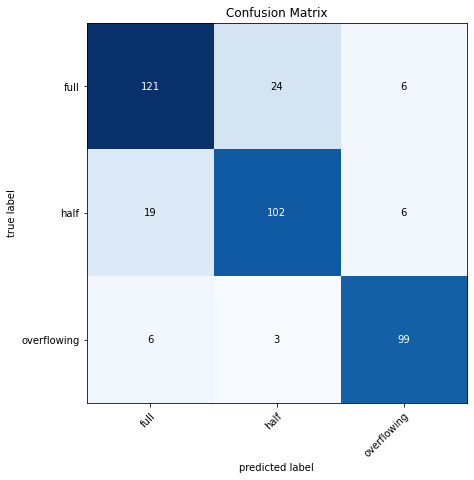

In [88]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,target=torch.from_numpy(targets).type(torch.float)
                         )

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names, #
    figsize=(10, 7))
ax.set_title("Confusion Matrix")

In [60]:
from typing import List, Tuple
def pred_and_plot_image(model: torch.nn.Module,
                        image_path : str,
                        class_names: List[str],
                        image_size: Tuple[int,int]=(224,224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = torchvision.transforms.Compose([transforms.Resize(image_size),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize(mean=[0.485,0.456,0.406],
                                                                               std=[0.229,0.224,0.225]) ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)
        
        target_image_pred = model(transformed_image).to(device)
    target_image_pred_prob = torch.softmax(target_image_pred,dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_prob,dim=1)
    
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_prob.max():.3f}")
    plt.axis(False)

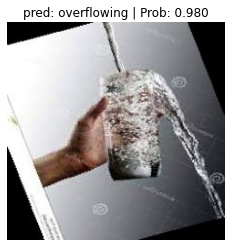

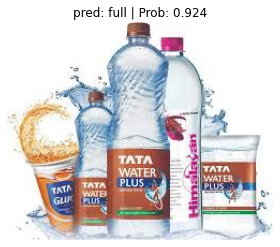

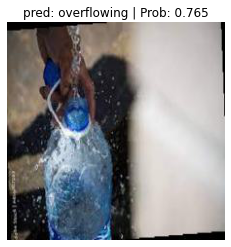

In [61]:
import random
num_images_to_plot=3
val_image_path_list = list(test_df["path"])
val_image_path_sample = random.sample(population=val_image_path_list,k=num_images_to_plot)
for image_path in val_image_path_sample:
    pred_and_plot_image(model=model,image_path=image_path,class_names=class_names,image_size=(224,224),device=device)
    